In [1]:
import warnings
from itertools import product
import glob
from datetime import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cartopy.feature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cartopy.feature as cf
import shapely.geometry as sgeom
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter


from sklearn.decomposition import PCA
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.metrics import davies_bouldin_score

import pickle
import copy
from shapely import geometry
from sklearn.metrics.pairwise import euclidean_distances
import statsmodels.api as sm
from scipy.stats import linregress

# Functions

In [2]:
def extract_region(data_array, regioncoords):
    """
    Extract a region from a DataArray with longitudes ranging from 0 to 360.
    Rearrange the data to have continuous longitudes even if the region wraps around 0 or 360 degrees.
    
    Parameters:
    data_array (xr.DataArray): Input DataArray with coordinates 'lon' (0 to 360) and 'lat'.
    min_lon (float): Minimum longitude of the region.
    max_lon (float): Maximum longitude of the region.
    min_lat (float): Minimum latitude of the region.
    max_lat (float): Maximum latitude of the region.
    
    Returns:
    xr.DataArray: Extracted region with continuous coordinates.
    """
    min_lon, max_lon, min_lat, max_lat = regioncoords

    # Handle the case where the region crosses the prime meridian or the International Date Line
    if min_lon > max_lon:
        # Split the region into two parts: one on the left of 0° and one on the right
        region1 = data_array.sel(
            lon=slice(min_lon, 360), 
            lat=slice(min_lat, max_lat)
        )
        region2 = data_array.sel(
            lon=slice(0, max_lon), 
            lat=slice(min_lat, max_lat)
        )

        # Combine the two parts along the longitude axis
        combined_region = xr.concat([region1, region2], dim='lon')

    else:
        # Directly slice the region
        combined_region = data_array.sel(
            lon=slice(min_lon, max_lon), 
            lat=slice(min_lat, max_lat)
        )

    # # Sort the longitudes to ensure they are in the correct order
    # combined_region = combined_region.sortby('lon')

    return combined_region
    
def compute_wrs(dataarray,n=5):
    dataflattened = dataarray.stack(flat=('lat','lon')).transpose('time','flat')
    
    pca_obj = PCA(12, whiten=True)
    pca_obj = pca_obj.fit(dataflattened)
    datatransformed = pca_obj.transform(dataflattened)

    variance_explained = np.sum(pca_obj.explained_variance_ratio_) * 100
    
    # train kmeans
    k_means = KMeans(n_clusters=n,
                     init='k-means++',
                     n_init=100,
                     max_iter=300,
                     tol=0.0001,
                     verbose=0,
                     random_state=42)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    return clusters_centers, labels, distances, variance_explained, datatransformed,k_means

def get_average_fields_for_centroids(dataarray,labels):
    centroids = np.unique(labels)
    avgs = []
    for centroid in centroids:
        wherecentroid = np.where(labels == centroid)[0]
        arr_selection = dataarray.isel(time=wherecentroid)
        averagefield = arr_selection.mean('time')
        avgs.append(averagefield)
    return centroids, avgs

import math

def plot_multiple_maps(da,freqs_labels,regioncoords,names = None, path_save=None, n_cols=2):
    """
    Plot multiple maps from a list of data arrays with a fixed number of columns and dynamic rows.
    
    Parameters:
    - da_list: list of xarray.DataArray objects to plot.
    - n_cols: Number of columns for the subplot grid (default is 2).
    """

    min_lon, max_lon, min_lat, max_lat = regioncoords
    # Convert longitudes from 0-360 to -180-180 if necessary
    def convert_lon(lon):
        return lon if lon <= 180 else lon - 360
    
    min_lon_converted = convert_lon(min_lon)
    max_lon_converted = convert_lon(max_lon)
    
    # Number of maps to plot
    n_maps = len(da.wr)
    
    # Determine the number of rows needed
    n_rows = math.ceil(n_maps / n_cols)
    
    # Create a figure with the calculated number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(9, 2 * (n_rows)),
                             subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-100)})

    # If there's only one row, axes will not be a 2D array, so we need to adjust for that
    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)
    
    # Plot each DataArray in the provided list
    for i in range(len(da.wr.values)-1):
        row = i // n_cols
        col = i % n_cols
        
        ax = axes[row, col]

        # Convert longitudes to -180 to 180 range
        lon = (da.lon + 180) % 360 - 180
    
        # Adjust data array to match the longitude range
        da_shifted, lon_shifted = xr.broadcast(da, lon)
        
        # Plot the rectangle to highlight the specified region
        rect_style = {'edgecolor': 'black', 'facecolor': 'gray', 'linewidth': 1.5, 'alpha':0.2}
        
        if min_lon_converted < max_lon_converted:
            # Normal case, region does not cross the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), max_lon_converted - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
        else:
            # Special case for regions crossing the antimeridian
            ax.add_patch(plt.Rectangle(
                (min_lon_converted, min_lat), 180 - min_lon_converted, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))
            ax.add_patch(plt.Rectangle(
                (-180, min_lat), max_lon_converted + 180, max_lat - min_lat,
                transform=ccrs.PlateCarree(), **rect_style, zorder=2))

        ax.set_extent([-100, 100, 10, 90], crs=ccrs.PlateCarree(central_longitude=-100))

        # Add gridlines every 20 degrees
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.2, color='gray', alpha=0.5, linestyle='--')
        gl.xlocator = plt.FixedLocator(np.arange(-180, 181, 60))
        gl.ylocator = plt.FixedLocator(np.arange(0, 91, 20))
        gl.top_labels = False
        gl.right_labels = False
        gl.xformatter = LongitudeFormatter(zero_direction_label=True)
        gl.yformatter = LatitudeFormatter()

        tick_fontsize = 10
        # Set font size for tick labels
        gl.xlabel_style = {'size': tick_fontsize}
        gl.ylabel_style = {'size': tick_fontsize}

        # Plot the data using pcolormesh
        mini=-2.5
        maxi=2.5
        intervals = 21
        bounds=np.linspace(mini,maxi,intervals)
        mesh = ax.contourf(lon_shifted.sel(wr=i).lon, da.lat, da_shifted.sel(wr=i).Z_anoms.values, levels=bounds, vmin=mini, vmax=maxi,
                                 cmap='RdYlBu_r', transform=ccrs.PlateCarree(),extend='both')

        # Add coastlines for context
        ax.coastlines()

        # Set title for each subplot
        if names:
            ax.set_title(f'{names[i]} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)
        else:
            ax.set_title(f'Cluster {i+1} - Freq.: {np.round(freqs_labels[i],2)}%',fontsize=11)

    # Hide any unused subplots
    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    # # Adjust layout to prevent overlapping
    plt.tight_layout(w_pad=0.1)
    # Alternatively, adjust spacing between plots using subplots_adjust
    # fig.subplots_adjust(hspace=-0.7, wspace=0.3)  # Adjust these parameters as needed


    cax = fig.add_axes([0.6, 0.2, 0.325, 0.03])  # Example position: horizontal, below the main plot
    
    # Add a horizontal colorbar
    cbar = fig.colorbar(mesh, cax=cax, orientation='horizontal')
    cbar.set_label(r'Z Anomaly ($\sigma$)')

    # main_title = f"Region: {min_lon,max_lon,min_lat,max_lat}"
    # Add the overall title for the figure
    fig.suptitle('ERA5 - Weather Regimes', fontsize=14, y=1.04,ha='center')

    if path_save==False:
        # Show the plot
        plt.show()
        plt.close('all')
    else:
        plt.savefig(path_save, bbox_inches='tight',dpi=200)
        plt.close('all')

In [3]:
def compute_pcs(dataarray):
    dataflattened = dataarray.stack(flat=('lat','lon')).transpose('time','flat')
    pca_obj = PCA(12, whiten=True)
    pca_obj = pca_obj.fit(dataflattened)
    datatransformed = pca_obj.transform(dataflattened)

    variance_explained = np.sum(pca_obj.explained_variance_ratio_) * 100
    return datatransformed, variance_explained
    
def compute_wrs_seeded(dataarray,n=5):
    dataflattened = dataarray.stack(flat=('lat','lon')).transpose('time','flat')
    
    pca_obj = PCA(12, whiten=True)
    pca_obj = pca_obj.fit(dataflattened)
    datatransformed = pca_obj.transform(dataflattened)

    variance_explained = np.sum(pca_obj.explained_variance_ratio_) * 100
    
    # train kmeans # transfer learning
    k_means = KMeans(n_clusters=n,
                     # init='k-means++',
                     init=era5_clusters_centers,
                     n_init=1,
                     max_iter=300, #(30/75) * 300
                     tol=0.0001,
                     verbose=0,
                     random_state=42)
    k_means.fit(datatransformed)
    clusters_centers = k_means.cluster_centers_
    labels = k_means.labels_
    distances = euclidean_distances(clusters_centers, datatransformed)

    return clusters_centers, labels, distances, variance_explained, datatransformed, k_means

In [4]:
def get_EOFs_from_PCs(PCs,da_region):
    # Assuming the original data matrix is called 'X' and has dimensions [N, M]
    # 'PC' is the principal components matrix and has dimensions [N, K]
    # We want to recover the 'EOF' matrix, which will have dimensions [M, K]
    
    # Calculate the pseudo-inverse of PC
    if isinstance(PCs, np.ndarray):
        PC_pseudo_inv = np.linalg.pinv(PCs)
    else:
        PC_pseudo_inv = np.linalg.pinv(PCs.values)
    
    # Compute the EOFs using the equation above
    EOF = np.dot(PC_pseudo_inv, da_region.stack(flat=('lat','lon')).transpose('time','flat'))
    
    # EOF will now have dimensions [K, M]. If you want [M, K], transpose the result.
    EOF = EOF.T
    
    nlat, nlon = len(da_region['lat']), len(da_region['lon'])  # Retrieve the number of latitudes and longitudes
    EOF_reshaped = EOF.reshape(nlat, nlon, EOF.shape[-1])  # Shape to [lat, lon, K]
    
    # Create an xarray.DataArray with appropriate coordinates and dimensions
    EOF_xr = xr.DataArray(
        EOF_reshaped,
        dims=['lat', 'lon', 'mode'],  # Specify dimensions: latitude, longitude, and mode (PC index)
        coords={
            'lat': da_region.coords['lat'],
            'lon': da_region.coords['lon'],
            'mode': np.arange(EOF.shape[-1])  # Create a mode coordinate [1, 2, ..., K]
        },
        name='EOFs'
    )
    return EOF_xr

In [5]:
import numpy as np
import xarray as xr

def reorder_model_eofs(obs_eofs, model_eofs):
    """
    Reorders the model EOFs to match the observation EOFs based on spatial correlation.

    Parameters:
    - obs_eofs: xarray.DataArray containing observation EOFs with dimensions [lat, lon, mode]
    - model_eofs: xarray.DataArray containing model EOFs with dimensions [lat, lon, mode]

    Returns:
    - reordered_indices: List containing the index of model EOFs that best match each observation EOF.
    """
    # Initialize a correlation matrix to store the spatial correlation between each pair of EOFs
    n_obs_modes = obs_eofs.shape[-1]  # Number of EOF modes in the observation
    n_model_modes = model_eofs.shape[-1]  # Number of EOF modes in the model

    # Flatten lat/lon dimensions for correlation calculation
    obs_flat = obs_eofs.stack(spatial=('lat', 'lon'))  # Shape: [spatial, mode]
    model_flat = model_eofs.stack(spatial=('lat', 'lon'))  # Shape: [spatial, mode]

    # Compute spatial correlation between each observation EOF and each model EOF
    correlation_matrix = np.zeros((n_obs_modes, n_model_modes))

    for i in range(n_obs_modes):
        # print(i)
        for j in range(n_model_modes):
            obs_eof = obs_flat.sel(mode=i)
            model_eof = model_flat.sel(mode=j)

            # Calculate Pearson correlation coefficient
            correlation = np.corrcoef(obs_eof, model_eof)[0,1]
            # correlation = xr.corr(obs_eof, model_eof, dim='spatial')
            correlation_matrix[i, j] = correlation

    # For each observation EOF, find the best matches among model EOFs
    reordered_indices = []
    signs = []  # Store +1 or -1 to indicate sign of correlation
    matched_model_eofs = set()

    for i in range(n_obs_modes):
        # Get the indices of model EOFs sorted by absolute correlation (highest to lowest)
        sorted_model_indices = np.argsort(-np.abs(correlation_matrix[i, :]))

        # Find the best available match that hasn't been used yet
        for best_match in sorted_model_indices:
            if best_match not in matched_model_eofs:
                reordered_indices.append(best_match)
                matched_model_eofs.add(best_match)
                
                # Determine the sign of correlation (+1 or -1) based on the actual correlation value
                sign = 1 if correlation_matrix[i, best_match] >= 0 else -1
                signs.append(sign)
                break

    return reordered_indices, signs

# Compute WRs

In [6]:
import pickle
# Load the saved object
with open('../Data_v3/k_means_model_era5_v3.pkl', 'rb') as f:
    k_means = pickle.load(f)
path_files = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ProcessedDataReanalyses/'

reanalysis = 'ERA5'
anoms_era5 = xr.open_dataset(f'{path_files}Z500FiltAnoms_{reanalysis}_v3.nc')
region = [180, 330, 20, 80]
data_region_era5 = extract_region(anoms_era5, region)
pcs_era5 = pd.read_csv(f'../Data/PCs_corrected/PCs_{reanalysis}_v3.csv',index_col=0,parse_dates=True, names=np.arange(0,12),skiprows=1)

clusters_centers = k_means.cluster_centers_
labels = k_means.labels_
cluster_centers = np.vstack([clusters_centers,np.zeros(12)])
distances = euclidean_distances(cluster_centers, pcs_era5.values)
labels_era5 = distances.argmin(axis=0)

In [7]:
EOF_ERA5 = get_EOFs_from_PCs(pcs_era5,data_region_era5.Z_anomalies)

In [8]:
path_anoms = '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/'
files = np.sort(glob.glob(f'{path_anoms}*'))

In [9]:
id_exp = 0
name_exp = files[id_exp].split('_')[-1][:-7]

anoms = xr.open_dataset(files[id_exp])
anoms = anoms.Z_anoms.compute()
anoms = anoms.sel(time=slice(None, '2014-12-31'))
region = [180, 330, 30, 80]
data_region = extract_region(anoms, region)
pcs_model, variance_explained_member = compute_pcs(data_region)
EOF_model = get_EOFs_from_PCs(pcs_model,data_region)
EOF_ERA5_modelcoords = EOF_ERA5.sel(lat=EOF_model.lat,lon=EOF_model.lon,method='nearest')
indices_pcs_ordered, signs_pcs = reorder_model_eofs(EOF_ERA5_modelcoords, EOF_model)
pcs_model = pcs_model[:,indices_pcs_ordered] * signs_pcs
pcs_model = pd.DataFrame(pcs_model,index = data_region.time)

distances_model = euclidean_distances(cluster_centers, pcs_model.values)
labels_model = distances_model.argmin(axis=0)
df_labels_model = pd.DataFrame(labels_model,index=pcs_model.index)
df_distances_model = pd.DataFrame(distances_model.min(axis=0),index=pcs_model.index)
df_labels_model.to_csv(f'../Data_v3/LENS2/Labels/df_labels_{name_exp}.csv')
df_distances_model.to_csv(f'../Data_v3/LENS2/Distances/df_labels_{name_exp}.csv')

centroids_model, avgs_model = get_average_fields_for_centroids(anoms, labels_model)

names = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]

avgs_model = xr.concat(avgs_model, dim='wr').to_dataset()
avgs_model.to_netcdf(f'../Data_v3/LENS2/avgs/avgs_{name_exp}.nc')

freqs_model = []
for label in np.unique(labels_model):
    freqs_model.append(100*len(labels_model[labels_model==label])/len(labels_model))

plot_multiple_maps(avgs_model,freqs_model,region,names=names, 
                   path_save=f'../Figures_v3/CompositesLENS/Composites_{name_exp}.png')

In [10]:
def extract_wrs(id_exp):
    name_exp = files[id_exp].split('_')[-1][:-7]
    
    anoms = xr.open_dataset(files[id_exp])
    anoms = anoms.Z_anoms.compute()
    anoms = anoms.sel(time=slice(None, '2014-12-31'))
    region = [180, 330, 30, 80]
    data_region = extract_region(anoms, region)
    pcs_model, variance_explained_member = compute_pcs(data_region)
    EOF_model = get_EOFs_from_PCs(pcs_model,data_region)
    EOF_ERA5_modelcoords = EOF_ERA5.sel(lat=EOF_model.lat,lon=EOF_model.lon,method='nearest')
    indices_pcs_ordered, signs_pcs = reorder_model_eofs(EOF_ERA5_modelcoords, EOF_model)
    pcs_model = pcs_model[:,indices_pcs_ordered] * signs_pcs
    pcs_model = pd.DataFrame(pcs_model,index = data_region.time)
    
    distances_model = euclidean_distances(cluster_centers, pcs_model.values)
    labels_model = distances_model.argmin(axis=0)
    df_labels_model = pd.DataFrame(labels_model,index=pcs_model.index)
    df_distances_model = pd.DataFrame(distances_model.min(axis=0),index=pcs_model.index)
    df_labels_model.to_csv(f'../Data_v3/LENS2/Labels/df_labels_{name_exp}.csv')
    df_distances_model.to_csv(f'../Data_v3/LENS2/Distances/df_labels_{name_exp}.csv')
    
    centroids_model, avgs_model = get_average_fields_for_centroids(anoms, labels_model)
    
    names = ["Greenland High", "Alaskan Ridge", "Pacific High", "Atlantic High", "Pacific Trough" ,"No WR"]
    
    avgs_model = xr.concat(avgs_model, dim='wr').to_dataset()
    avgs_model.to_netcdf(f'../Data_v3/LENS2/avgs/avgs_{name_exp}.nc')
    
    freqs_model = []
    for label in np.unique(labels_model):
        freqs_model.append(100*len(labels_model[labels_model==label])/len(labels_model))
    
    plot_multiple_maps(avgs_model,freqs_model,region,names=names, 
                       path_save=f'../Figures_v3/CompositesLENS/Composites_{name_exp}.png')

In [11]:
from multiprocessing import Pool

num_ids = len(files)
num_processors = 17

# Create a Pool of worker processes
with Pool(processes=num_processors) as pool:
    # Map the function to the range of IDs
    pool.map(extract_wrs, range(num_ids))

In [23]:
extract_wrs(1)

In [22]:
files

array(['/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1011.001.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1031.002.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1051.003.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1071.004.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1091.005.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1111.006.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1131.007.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1151.008.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE2-1171.009.cam.nc',
       '/glade/derecho/scratch/jhayron/Data4WRsClimateChange/LENS_poly_v3/anoms_LE

array([4, 1, 0, 2, 4])

In [43]:
corrs_avgs

[-0.0872826186561212,
 0.026196103226161015,
 -0.006891529903634263,
 0.029632928063358342,
 0.06084639934178798]

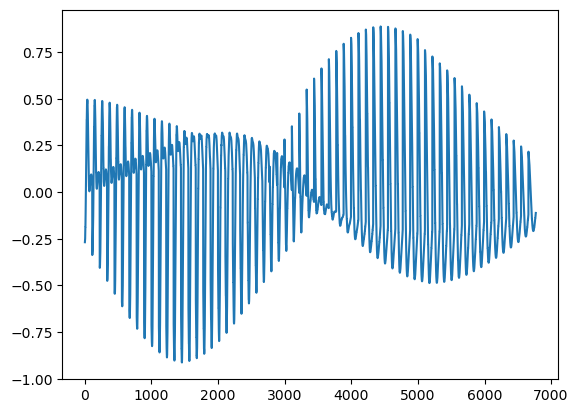

In [38]:
plt.plot(avg_temp_lens.values.flatten())

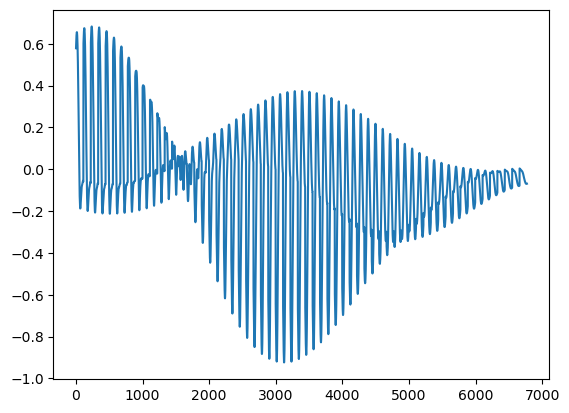

In [39]:
plt.plot(region_avg_temp.values.flatten())

In [32]:
region_avg_temp - avg_temp_lens

ValueError: cannot reindex or align along dimension 'lon' because the (pandas) index has duplicate values

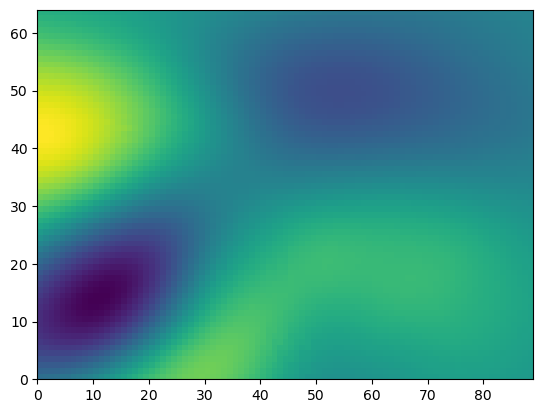

In [23]:
plt.pcolormesh(extract_region(avgs[0],region))

In [18]:
extract_region(avgs[0],region)

<xarray.DataArray 'Z_anoms' (lat: 64, lon: 89)>
array([[-0.26851616, -0.26479745, -0.25688821, ...,  0.06421305,
         0.05819826,  0.05195828],
       [-0.33711217, -0.33538803, -0.33076415, ...,  0.07332515,
         0.06659559,  0.05981063],
       [-0.40496386, -0.40574124, -0.40485579, ...,  0.08154206,
         0.07444087,  0.06699488],
       ...,
       [ 0.27643674,  0.27189654,  0.26678672, ..., -0.13522441,
        -0.1309201 , -0.12658247],
       [ 0.24491571,  0.24064265,  0.23591067, ..., -0.13033688,
        -0.12486071, -0.11973715],
       [ 0.21678348,  0.21276059,  0.20836927, ..., -0.12026391,
        -0.11581838, -0.1115683 ]])
Coordinates:
  * lat      (lat) float64 20.26 21.2 22.15 23.09 ... 76.81 77.75 78.69 79.63
  * lon      (lon) float64 200.0 201.2 202.5 203.8 ... 306.2 307.5 308.8 310.0

In [11]:
era5_avgs

[<xarray.DataArray 'Z_anoms' (lat: 81, lon: 360)>
 array([[ 0.05992974,  0.06124612,  0.06291714, ...,  0.05581258,
          0.05771309,  0.05913733],
        [ 0.05536201,  0.05664912,  0.05820152, ...,  0.05118521,
          0.05305047,  0.05437215],
        [ 0.0499158 ,  0.05114054,  0.05248632, ...,  0.04625266,
          0.04767193,  0.04901401],
        ...,
        [-0.02821182, -0.02817044, -0.02812994, ..., -0.02833466,
         -0.02829406, -0.02825309],
        [-0.0264073 , -0.02639377, -0.02637996, ..., -0.02644602,
         -0.0264333 , -0.02642073],
        [-0.02417998, -0.02417998, -0.02417998, ..., -0.02417998,
         -0.02417998, -0.02417998]])
 Coordinates:
   * lat      (lat) int64 10 11 12 13 14 15 16 17 18 ... 83 84 85 86 87 88 89 90
   * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359,
 <xarray.DataArray 'Z_anoms' (lat: 81, lon: 360)>
 array([[-0.22413   , -0.22411858, -0.22405188, ..., -0.22381606,
         -0.22404214, -0.2244362

In [9]:
avgs

[<xarray.DataArray 'Z_anoms' (lat: 85, lon: 288)>
 array([[-0.01167562, -0.00955207, -0.01251971, ..., -0.00944087,
         -0.00960417, -0.01046615],
        [-0.02155894, -0.02154832, -0.02279924, ..., -0.01857713,
         -0.01917259, -0.02086844],
        [-0.02881274, -0.02955286, -0.03053752, ..., -0.02516455,
         -0.02661747, -0.02816821],
        ...,
        [ 0.06339969,  0.06405761,  0.06471799, ...,  0.06145284,
          0.06209824,  0.0627469 ],
        [ 0.0713944 ,  0.07162206,  0.07185217, ...,  0.07071597,
          0.07094102,  0.07116653],
        [ 0.07898826,  0.07898819,  0.07898802, ...,  0.07898808,
          0.07898801,  0.07898895]])
 Coordinates:
   * lat      (lat) float64 10.84 11.78 12.72 13.66 ... 87.17 88.12 89.06 90.0
   * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8,
 <xarray.DataArray 'Z_anoms' (lat: 85, lon: 288)>
 array([[-0.0544359 , -0.05674674, -0.0556941 , ..., -0.05386303,
         -0.05428184, -0.05450194],


In [58]:
freqs = []
for label in np.unique(labels):
    freqs.append(100*len(labels[labels==label])/len(labels))

names_wrs = ['Pacific Trough', 'Pacific High', 'Alaskan Ridge', 'Greenland High', 'West Coast High']

plot_multiple_maps(initial_avgs,freqs,region,names_wrs,
    path_save=f'../ResultsLENS_Historic/MapsCentroids/MapsCentroids_{name_exp}.png',save=True)

In [55]:
name_exp

'LE2-1001.001'

In [34]:
era5_datatransformed.shape

(27394, 12)

In [3]:
path_anoms = "/glade/derecho/scratch/jhayron/Data4WRsClimateChange/ERA5/z_anoms_rolling_filtered.nc"
anoms = xr.open_dataset(path_anoms).__xarray_dataarray_variable__
anoms = anoms.to_dataset(name='Z_anoms')
anoms = anoms.Z_anoms.compute()
anoms = anoms.sel(time=slice(None, '2014-12-31'))

region = [200, 310, 20, 80]
data_region = extract_region(anoms, region)
data_region = data_region.sel(time=slice(None, '2014-12-31'))

In [4]:
# initial_clusters_centers, initial_labels, initial_distances, variance_explained, datatransformed, k_means_object = compute_wrs(data_region)

In [5]:
# np.save('../ResultsERA5_v2/k_means_files/initial_clusters_centers.npy',initial_clusters_centers)
# np.save('../ResultsERA5_v2/k_means_files/initial_labels.npy',initial_labels)
# np.save('../ResultsERA5_v2/k_means_files/initial_distances.npy',initial_distances)
# np.save('../ResultsERA5_v2/k_means_files/variance_explained.npy',variance_explained)
# np.save('../ResultsERA5_v2/k_means_files/data_transformed.npy',datatransformed)

In [6]:
# # save
# with open('../ResultsERA5_v2/k_means_files/k_means_model.pkl','wb') as f:
#     pickle.dump(k_means_object,f)

In [7]:
initial_clusters_centers = np.load('../ResultsERA5_v2/k_means_files/initial_clusters_centers.npy')
initial_labels = np.load('../ResultsERA5_v2/k_means_files/initial_labels.npy')
initial_distances = np.load('../ResultsERA5_v2/k_means_files/initial_distances.npy')
variance_explained = np.load('../ResultsERA5_v2/k_means_files/variance_explained.npy')
datatransformed = np.load('../ResultsERA5_v2/k_means_files/data_transformed.npy')

# load
with open('../ResultsERA5_v2/k_means_files/k_means_model.pkl', 'rb') as f:
    k_means_object = pickle.load(f)

In [8]:
initial_centroids, initial_avgs = get_average_fields_for_centroids(anoms, initial_labels)

In [9]:
freqs = []
for label in np.unique(initial_labels):
    freqs.append(100*len(initial_labels[initial_labels==label])/len(initial_labels))

In [10]:
names_wrs = ['Pacific Trough', 'Pacific High', 'Alaskan Ridge', 'Greenland High', 'West Coast High']

In [11]:
plot_multiple_maps(initial_avgs,freqs,region,names_wrs,
    path_save=f'../ResultsERA5_v3/MapsCentroids_Initial.png',save=True)

In [12]:
freqs

[22.092428999050888,
 20.694312623202162,
 16.21888004672556,
 19.212236256114476,
 21.782142074906915]

In [13]:
new_cluster_centers = np.vstack([initial_clusters_centers,np.zeros(12)])

In [14]:
# weather_patterns = k_means.predict(z500_anoms_transformed)
new_distances= euclidean_distances(new_cluster_centers, datatransformed)
new_labels = new_distances.argmin(axis=0)

In [15]:
from sklearn.metrics import accuracy_score

In [16]:
accuracy_score(initial_labels,new_labels)

0.8955975761115573

In [17]:
new_centroids, new_avgs = get_average_fields_for_centroids(anoms, new_labels)

In [18]:
new_freqs = []
for label in np.unique(new_labels):
    new_freqs.append(100*len(new_labels[new_labels==label])/len(new_labels))

In [22]:
plot_multiple_maps(new_avgs[:-1],new_freqs,region,names_wrs,
    path_save=f'../ResultsERA5_v3/MapsCentroids_withClimoClass.png',save=True)

In [23]:
new_freqs

[19.668540556326203,
 18.573410235818063,
 15.010586259764912,
 17.182594728772724,
 19.124625830473825,
 10.440242388844272]

In [24]:
names_wrs_withclimo = ['Pacific Trough', 'Pacific High', 'Alaskan Ridge', 'Greenland High', 'West Coast High','No WR']

In [25]:
np.save('../ResultsERA5_v3/k_means_files/new_cluster_centers.npy',new_cluster_centers)
np.save('../ResultsERA5_v3/k_means_files/new_labels.npy',new_labels)
np.save('../ResultsERA5_v3/k_means_files/new_distances.npy',new_distances)

# Climatology of frequency and persistence... average # events per season, median persistence per season

In [26]:
path_figs = '../ResultsERA5_v3/'

## Seasonal frequency

In [27]:
df_labels = pd.DataFrame(new_labels,index=anoms.time)

In [28]:
df_labels.columns = ['class']

In [29]:
# 1. Compute Overall Frequency of Each Class
overall_frequency = df_labels['class'].value_counts().sort_index()
print("Overall Frequency of Each Class:")
print(overall_frequency)

# 2. Compute Frequency of Each Class Per Season
# Add a column for the season
# Define seasons (Northern Hemisphere: Winter - DJF, Spring - MAM, Summer - JJA, Autumn - SON)
df_labels['season'] = df_labels.index.month % 12 // 3 + 1  # This will give: 1=DJF, 2=MAM, 3=JJA, 4=SON

# Map season numbers to season names
season_map = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df_labels['season'] = df_labels['season'].map(season_map)

# Group by season and class to count the frequency
seasonal_frequency = df_labels.groupby(['season', 'class']).size().unstack(fill_value=0)

print("\nFrequency of Each Class Per Season:")
print(seasonal_frequency)

# To display as percentage per season
seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
print("\nPercentage of Each Class Per Season:")
print(seasonal_percentage)

Overall Frequency of Each Class:
0    5388
1    5088
2    4112
3    4707
4    5239
5    2860
Name: class, dtype: int64

Frequency of Each Class Per Season:
class      0     1     2     3     4    5
season                                   
Fall    1522  1325   954  1014  1199  811
Spring  1397  1337  1085  1486   904  691
Summer  1005   825  1060  1013  2127  870
Winter  1464  1601  1013  1194  1009  488

Percentage of Each Class Per Season:
class           0          1          2          3          4          5
season                                                                  
Fall    22.300366  19.413919  13.978022  14.857143  17.567766  11.882784
Spring  20.246377  19.376812  15.724638  21.536232  13.101449  10.014493
Summer  14.565217  11.956522  15.362319  14.681159  30.826087  12.608696
Winter  21.628010  23.651943  14.965283  17.639238  14.906190   7.209337


In [30]:
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

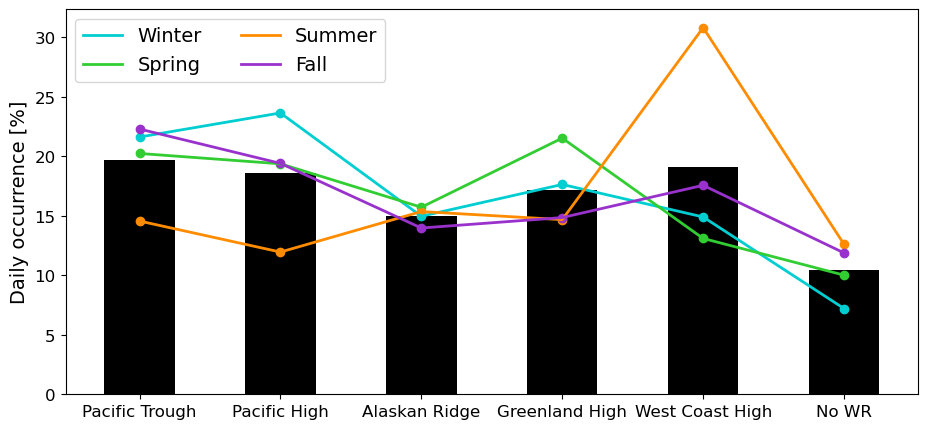

In [31]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,100*overall_frequency/np.sum(overall_frequency),width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,seasonal_percentage.loc[seasons[iseason]],color=colors_seasons[iseason],
             lw=2,
             label=seasons[iseason])
    plt.scatter(names_wrs_withclimo,seasonal_percentage.loc[seasons[iseason]],color=colors_seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=14,ncol=2)
plt.ylabel('Daily occurrence [%]',fontsize=14)
plt.savefig(f'{path_figs}SeasonalFreqs.png',bbox_inches='tight')

## Seasonal eventwise occurrence and duration

In [126]:
# Step 1: Identify changes in class to find the start of each event
df_labels['shifted'] = df_labels['class'].shift(1)
df_labels['start'] = df_labels['class'] != df_labels['shifted']
df_labels['start_date'] = df_labels.index.where(df_labels['start'], pd.NaT)
df_labels['start_date'].fillna(method='ffill', inplace=True)

# Step 2: Calculate the duration of each event
# Convert the Timedelta to its 'days' component
df_labels['duration'] = (df_labels.index - df_labels['start_date']).dt.days + 1

# Step 3: Create the df_events DataFrame
# Group by 'start_date' and 'class' to get the duration of each class event
df_events = df_labels.groupby(['start_date', 'class']).agg({'duration': 'max'}).reset_index()

# Drop the temporary columns used for calculations
df_labels.drop(columns=['shifted', 'start', 'start_date', 'duration'], inplace=True)

# Set 'start_date' as the index if needed
df_events.set_index('start_date', inplace=True)

# Display the resulting DataFrame
print(df_events)

            class  duration
start_date                 
1940-01-01      3         5
1940-01-06      2         7
1940-01-13      3        10
1940-01-23      2         4
1940-01-27      5         1
...           ...       ...
2014-11-26      2        10
2014-12-06      0        16
2014-12-22      3         1
2014-12-23      5         3
2014-12-26      2         6

[5040 rows x 2 columns]


In [127]:
# df_events = df_events[df_events['duration']>=3]

In [128]:
# Total number of events for each class
total_events_per_class = df_events.groupby('class').size()
print("Total number of events per class:")
print(total_events_per_class)

# Extract the years from the 'start_date' index
df_events['year'] = df_events.index.year

# Calculate the number of unique years in the dataset
total_years = df_events['year'].nunique()

# Calculate the average frequency of events per year for each class
average_frequency_per_year = total_events_per_class / total_years
print("\nAverage frequency of events per year for each class:")
print(average_frequency_per_year)

# Define seasons as a dictionary mapping month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'

# Add a 'season' column to the DataFrame
df_events['season'] = df_events.index.month.map(get_season)

# Calculate the number of events for each class per season
events_per_season = df_events.groupby(['class', 'season']).size().unstack(fill_value=0)
print("\nNumber of events per class per season:")
print(events_per_season)

# Calculate the average frequency of events per season for each class
# Number of unique years might differ if not every season is present each year
average_frequency_per_season = events_per_season / total_years
print("\nAverage frequency of events per season for each class:")
print(average_frequency_per_season)


Total number of events per class:
class
0     812
1     788
2     667
3     740
4     833
5    1200
dtype: int64

Average frequency of events per year for each class:
class
0    10.826667
1    10.506667
2     8.893333
3     9.866667
4    11.106667
5    16.000000
dtype: float64

Number of events per class per season:
season  Fall  Spring  Summer  Winter
class                               
0        232     222     160     198
1        217     210     164     197
2        159     170     187     151
3        179     216     180     165
4        222     189     254     168
5        339     297     347     217

Average frequency of events per season for each class:
season      Fall    Spring    Summer    Winter
class                                         
0       3.093333  2.960000  2.133333  2.640000
1       2.893333  2.800000  2.186667  2.626667
2       2.120000  2.266667  2.493333  2.013333
3       2.386667  2.880000  2.400000  2.200000
4       2.960000  2.520000  3.386667  2.240000
5

In [129]:
# Assuming `average_frequency_per_year` and `average_frequency_per_season` are already computed
# Make sure the seasons are ordered
seasons = ['Winter', 'Spring', 'Summer', 'Fall']

# Reorder the columns to follow the seasonal order
average_frequency_per_season = average_frequency_per_season[seasons]

# To create the stacked bar plot, we need to calculate the cumulative sums for each class.
# This helps in stacking the bars correctly.
cumulative_frequencies = average_frequency_per_season.cumsum(axis=1)

# The bottom for each stack starts from the previous cumulative value.
bottoms = cumulative_frequencies.shift(axis=1).fillna(0)

# Define colors for each season
season_colors = {
    'Winter': 'darkturquoise',
    'Spring': 'limegreen',
    'Summer': 'darkorange',
    'Fall': 'darkorchid'
}


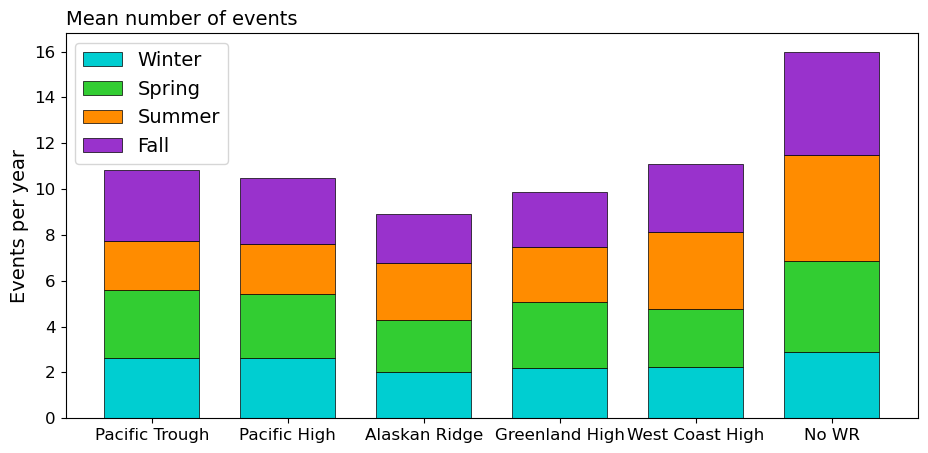

In [130]:
# Set up the plot
fig, ax = plt.subplots(figsize=(11, 5))

# Loop through each season to plot the stacked bars
for season in seasons:
    ax.bar(
        average_frequency_per_season.index,   # X-axis labels are the classes
        average_frequency_per_season[season], # The height of each bar section
        bottom=bottoms[season],               # The bottom starts from the cumulative sum of previous sections
        color=season_colors[season],          # Color for each season
        label=season,                          # Label for the legend
        edgecolor = "k",
        linewidth = 0.5,
        width=0.7
    )

# Add labels and title
ax.set_ylabel('Events per year',fontsize=14)
ax.set_title('Mean number of events',loc='left',fontsize=14)
ax.legend(fontsize=14)

# Display the plot
plt.xticks(average_frequency_per_season.index,names_wrs_withclimo,fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(f'{path_figs}NumberOfEvents_YearSeason.png',bbox_inches='tight')


In [131]:
# Calculate mean duration of events for each class overall
mean_duration_overall = df_events.groupby('class')['duration'].mean()

print("Mean Duration Overall:")
print(mean_duration_overall)


Mean Duration Overall:
class
0    6.635468
1    6.456853
2    6.164918
3    6.360811
4    6.289316
5    2.383333
Name: duration, dtype: float64


In [132]:
# Extract the season from the start_date (customize this based on your date ranges for each season)
def get_season(month):
    if 3 <= month <= 5:
        return 'Spring'
    elif 6 <= month <= 8:
        return 'Summer'
    elif 9 <= month <= 11:
        return 'Fall'
    else:
        return 'Winter'

# Add a 'season' column to df_events
df_events['season'] = df_events.index.month.map(get_season)

# Calculate mean duration of events for each class stratified by seasons
mean_duration_by_season = df_events.groupby(['season', 'class'])['duration'].mean()

print("\nMean Duration by Season:")
print(mean_duration_by_season)



Mean Duration by Season:
season  class
Fall    0        6.672414
        1        6.608295
        2        5.880503
        3        5.469274
        4        5.391892
        5        2.345133
Spring  0        6.734234
        1        5.909524
        2        6.152941
        3        6.388889
        4        4.947090
        5        2.309764
Summer  0        5.568750
        1        5.000000
        2        5.721925
        3        5.738889
        4        8.381890
        5        2.553314
Winter  0        7.343434
        1        8.086294
        2        7.026490
        3        7.969697
        4        5.821429
        5        2.271889
Name: duration, dtype: float64


In [133]:
mean_duration_overall

class
0    6.635468
1    6.456853
2    6.164918
3    6.360811
4    6.289316
5    2.383333
Name: duration, dtype: float64

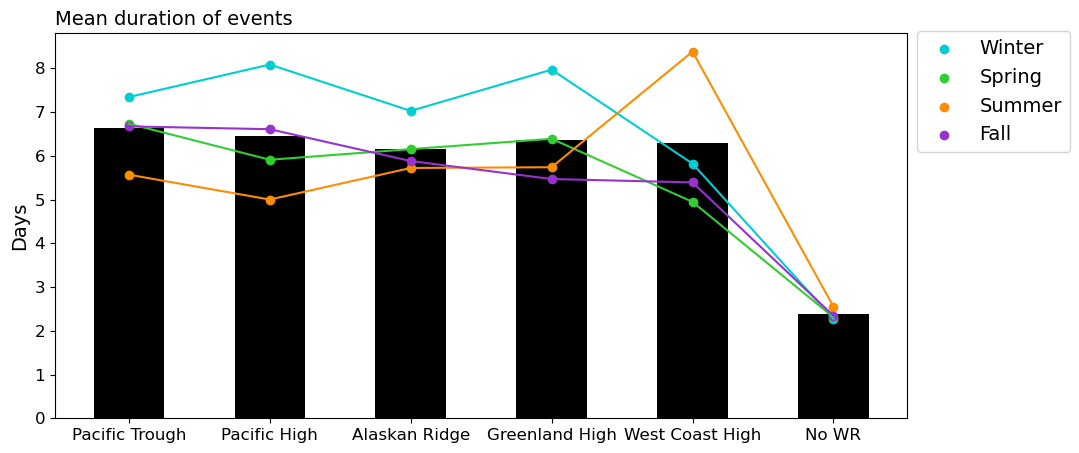

In [134]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,mean_duration_overall,width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,mean_duration_by_season.loc[seasons[iseason]],color=colors_seasons[iseason])
    plt.scatter(names_wrs_withclimo,mean_duration_by_season.loc[seasons[iseason]],color=colors_seasons[iseason],label=seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1., 1.03),fontsize=14)
plt.ylabel('Days',fontsize=14)
plt.title('Mean duration of events',loc='left',fontsize=14)
plt.savefig(f'{path_figs}SeasonalDuration.png',bbox_inches='tight')

# Now let's do rolling windows of N years and check how characteristics change with time

In [135]:
df_distances = pd.DataFrame(new_distances.min(axis=0),index=df_labels.index)

In [136]:
df_distances['season'] = df_labels['season']

In [137]:
df_distances.columns = ['distance','season']

In [138]:
df_distances['class'] = df_labels['class']

In [139]:
df_distances

distance  season  class
1940-01-01  3.451557  Winter      3
1940-01-02  3.406165  Winter      3
1940-01-03  3.428151  Winter      3
1940-01-04  3.471114  Winter      3
1940-01-05  3.513341  Winter      3
...              ...     ...    ...
2014-12-27  2.683519  Winter      2
2014-12-28  2.877114  Winter      2
2014-12-29  3.224855  Winter      2
2014-12-30  3.496143  Winter      2
2014-12-31  3.650350  Winter      2

[27394 rows x 3 columns]

In [140]:
df_labels

class  season
1940-01-01      3  Winter
1940-01-02      3  Winter
1940-01-03      3  Winter
1940-01-04      3  Winter
1940-01-05      3  Winter
...           ...     ...
2014-12-27      2  Winter
2014-12-28      2  Winter
2014-12-29      2  Winter
2014-12-30      2  Winter
2014-12-31      2  Winter

[27394 rows x 2 columns]

In [141]:
df_events

class  duration  year  season
start_date                               
1940-01-01      3         5  1940  Winter
1940-01-06      2         7  1940  Winter
1940-01-13      3        10  1940  Winter
1940-01-23      2         4  1940  Winter
1940-01-27      5         1  1940  Winter
...           ...       ...   ...     ...
2014-11-26      2        10  2014    Fall
2014-12-06      0        16  2014  Winter
2014-12-22      3         1  2014  Winter
2014-12-23      5         3  2014  Winter
2014-12-26      2         6  2014  Winter

[5040 rows x 4 columns]

In [142]:
def extract_n_years_around_each_year(df, N):
    """
    Extracts N years of data around each year from the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing time-indexed data.
    - N (int): Number of years to extract around each year.

    Returns:
    - dict: A dictionary where each key is a year and the corresponding value is a DataFrame
            containing N years of data centered around that year.
    """
    # Initialize an empty dictionary to store results
    result_dict = {}

    # Iterate over each unique year in the index
    for year in df.index.year.unique():
        # Define the range of years to extract
        start_year = year - N
        end_year = year + N

        # Extract data for the range of years
        data_subset = df[(df.index.year >= start_year) & (df.index.year <= end_year)]

        # Store the extracted data in the result dictionary
        result_dict[year] = data_subset

    return result_dict


In [143]:
N=30
# Example usage:
# Assuming df is your DataFrame with a datetime index
# Replace with your actual DataFrame and adjust N as needed

dict_labels = extract_n_years_around_each_year(df_labels, N)
dict_distances = extract_n_years_around_each_year(df_distances, N)
dict_events = extract_n_years_around_each_year(df_events, N)

## trends in frequency

In [144]:
def get_frequencies_labels(df_labels_temp):
    # 1. Compute Overall Frequency of Each Class
    overall_frequency = df_labels_temp['class'].value_counts().sort_index()
    overall_frequency = overall_frequency*100/np.sum(overall_frequency)

    # Group by season and class to count the frequency
    seasonal_frequency = df_labels_temp.groupby(['season', 'class']).size().unstack(fill_value=0)
    seasonal_percentage = seasonal_frequency.div(seasonal_frequency.sum(axis=1), axis=0) * 100
    return overall_frequency,seasonal_percentage

In [145]:
years_trends = df_labels.index.year.unique()#[0+N//2:-N//2]

In [146]:
series_frequencies = []
series_frequencies_seasonal = {}
for season in seasons:
    series_frequencies_seasonal[season] = []

for year in years_trends:
    series_frequencies.append(get_frequencies_labels(dict_labels[year])[0].values)
    for season in seasons:
        series_frequencies_seasonal[season].append(get_frequencies_labels(dict_labels[year])[1].loc[season])

series_frequencies = np.array(series_frequencies)
for season in seasons:
    series_frequencies_seasonal[season] = np.array(series_frequencies_seasonal[season])

In [147]:
years_trends

Int64Index([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
            1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
            1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
            1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
            1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
            1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
            2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014],
           dtype='int64')

In [148]:
def compute_trend_significance(series):
    ### COMPUTE TRENDS AND SIGNIFICANCE
    # Linear regression using statsmodels
    X = sm.add_constant(series.index)  # Add a constant (intercept) to the model
    model = sm.OLS(series, X).fit()  # Fit the model
    # Extract the slope (trend) and its p-value
    # return model
    s = model.params.x1
    p = model.pvalues.x1
    return s, p

*** Pacific Trough ***
Trend (slope): 0.3121957470251738 % per decade
P-value: 4.784438530608597e-36
*** Pacific Trough Winter ***
Trend (slope): 0.3090093611912951 % per decade
P-value: 2.2881841846843517e-17
*** Pacific Trough Spring ***
Trend (slope): 0.44077769971293596 % per decade
P-value: 1.277072303093559e-21
*** Pacific Trough Summer ***
Trend (slope): 0.39377978536863023 % per decade
P-value: 2.20942224531301e-36
*** Pacific High Spring ***
Trend (slope): -0.2925815391722452 % per decade
P-value: 6.123056237538202e-10
*** Alaskan Ridge ***
Trend (slope): -0.1798471978153488 % per decade
P-value: 6.924410909824337e-35
*** Alaskan Ridge Winter ***
Trend (slope): -0.34564269691327615 % per decade
P-value: 2.0403130664864087e-38
*** Alaskan Ridge Summer ***
Trend (slope): -0.36337234073355906 % per decade
P-value: 8.87840756504339e-25
*** Alaskan Ridge Fall ***
Trend (slope): -0.12368400643471965 % per decade
P-value: 4.757864894914311e-13
*** Greenland High ***
Trend (slope): 0.

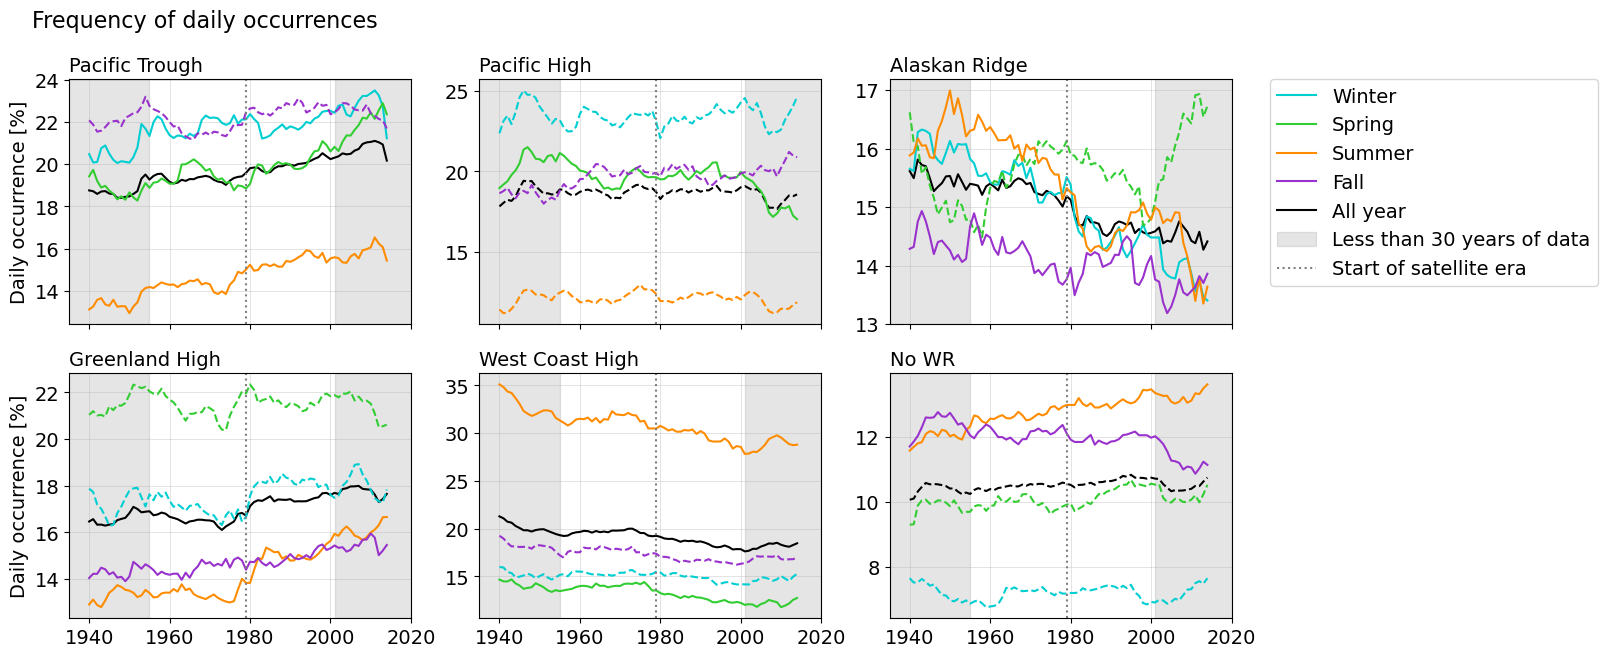

In [149]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_frequencies[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp[0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
    if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} % per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_frequencies[:, wr], color='k')
    else:
        ax.plot(years_trends, series_frequencies[:, wr], color='k',ls = '--')
    
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_frequencies_seasonal[season][:, wr],index=years_trends)
        ### COMPUTE TRENDS AND SIGNIFICANCE
        slope, p_value = compute_trend_significance(df_temp[0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
        if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} % per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_frequencies_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_frequencies_seasonal[season][:, wr], color=colors_seasons[iseason], ls = '--')
            
        ax.plot([1,2],series_frequencies_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_frequencies_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2001, 2020, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1935,2020)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('Daily occurrence [%]',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Frequency of daily occurrences',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalFrequencyTrends',bbox_inches='tight')


## Trends in distance from centroid

In [150]:
overall_mean_distances = df_distances.groupby(['class']).mean()
seasonal_distances = df_distances.groupby(['season','class']).mean()

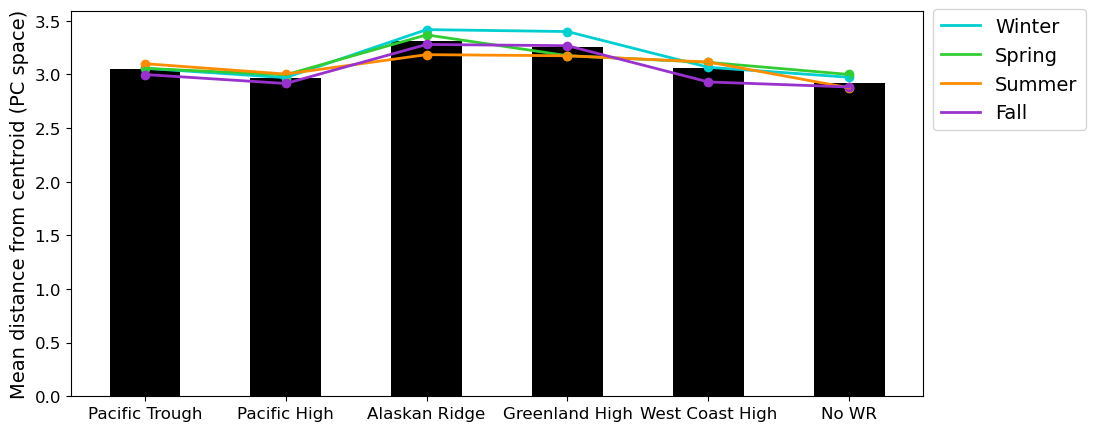

In [151]:
plt.figure(figsize=(11,5))
plt.bar(names_wrs_withclimo,overall_mean_distances.distance,width=0.5,color='k')

colors_seasons = ['darkturquoise','limegreen','darkorange','darkorchid']

for iseason in range(len(seasons)):
    plt.plot(names_wrs_withclimo,seasonal_distances.loc[seasons[iseason]].distance,color=colors_seasons[iseason],
             lw=2,
             label=seasons[iseason])
    plt.scatter(names_wrs_withclimo,seasonal_distances.loc[seasons[iseason]].distance,color=colors_seasons[iseason])

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1., 1.03),fontsize=14)
plt.ylabel('Mean distance from centroid (PC space)',fontsize=14)
plt.savefig(f'{path_figs}SeasonalDistances.png',bbox_inches='tight')

In [152]:
def get_mean_distances(df_distances_temp):
    overall_mean_distances = df_distances_temp.groupby(['class']).mean()
    seasonal_distances = df_distances_temp.groupby(['season','class']).mean()
    return overall_mean_distances.distance, seasonal_distances.distance

In [153]:
series_distances = []
series_distances_seasonal = {}
for season in seasons:
    series_distances_seasonal[season] = []

for year in years_trends:
    series_distances.append(get_mean_distances(dict_distances[year])[0].values)
    for season in seasons:
        series_distances_seasonal[season].append(get_mean_distances(dict_distances[year])[1].loc[season].values)

series_distances = np.array(series_distances)
for season in seasons:
    series_distances_seasonal[season] = np.array(series_distances_seasonal[season])

*** Pacific Trough Spring ***
Trend (slope): 0.008763168550760918 per decade
P-value: 2.575480280380236e-21
*** Pacific High ***
Trend (slope): -0.012668567909517921 per decade
P-value: 1.2710666428113966e-39
*** Pacific High Winter ***
Trend (slope): -0.01617498049648957 per decade
P-value: 7.350051778769907e-31
*** Pacific High Summer ***
Trend (slope): -0.025080272472949305 per decade
P-value: 1.0473134067611698e-29
*** Alaskan Ridge Winter ***
Trend (slope): 0.008022848556837932 per decade
P-value: 1.3552254739279716e-12
*** Alaskan Ridge Fall ***
Trend (slope): -0.011174698459202343 per decade
P-value: 1.2557350714808415e-25
*** West Coast High ***
Trend (slope): -0.001946830370276216 per decade
P-value: 2.786955019103499e-05
*** West Coast High Winter ***
Trend (slope): -0.014661415701186023 per decade
P-value: 3.6954917594088095e-37
*** West Coast High Spring ***
Trend (slope): -0.00964332912094152 per decade
P-value: 1.2183114755969785e-18
*** West Coast High Fall ***
Trend (sl

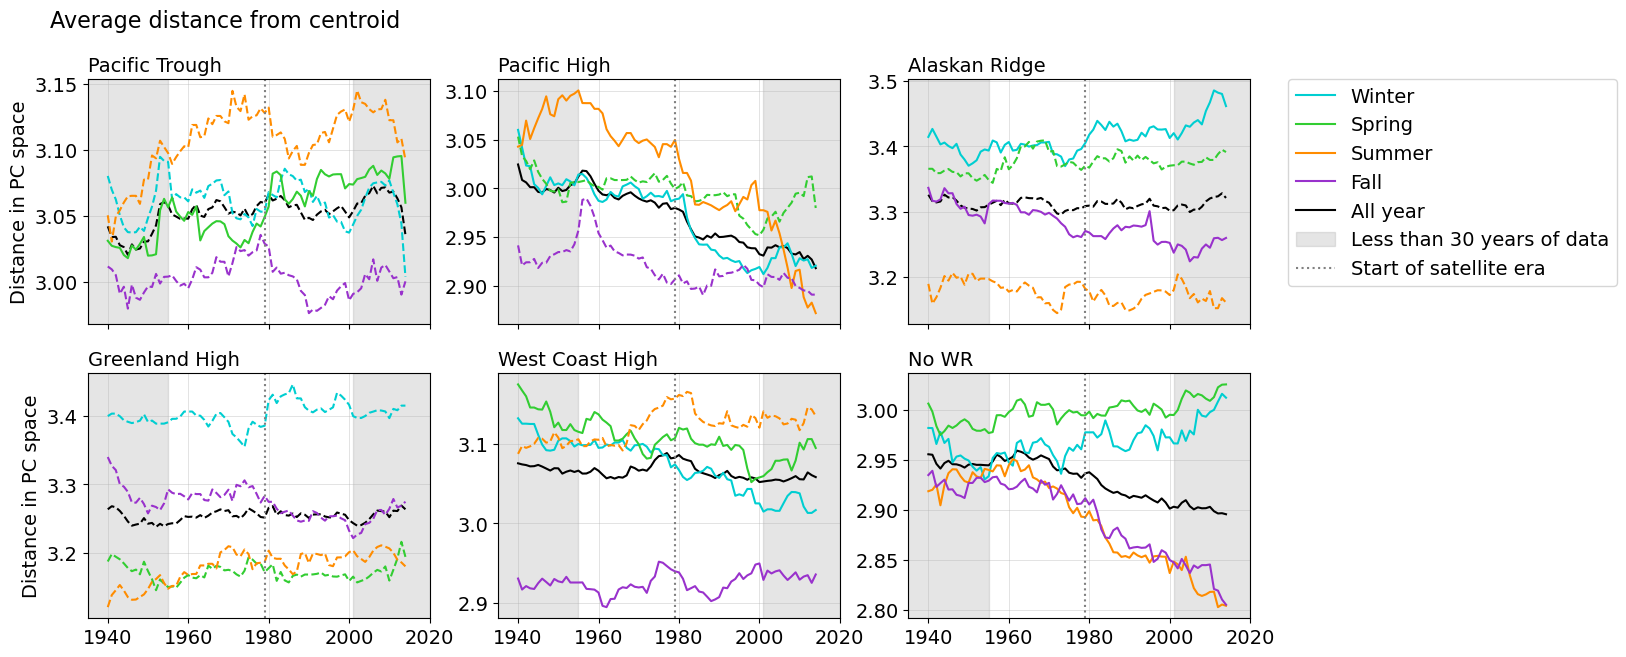

In [154]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_distances[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp[0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
    if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_distances[:, wr], color='k')
    else:
        ax.plot(years_trends, series_distances[:, wr], color='k',ls = '--')
        
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_distances_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp[0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
        if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_distances_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_distances_seasonal[season][:, wr], color=colors_seasons[iseason],ls='--')
        ax.plot([1,2],series_distances_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_distances_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2001, 2020, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1935,2020)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel(r'Distance in PC space',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average distance from centroid',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalDistancesTrends',bbox_inches='tight')


# Trends in events

In [155]:
def get_event_freqs(df_events_temp):
    # Total number of events for each class
    total_events_per_class = df_events_temp.groupby('class').size()
    
    # Calculate the number of unique years in the dataset
    total_years = df_events_temp['year'].nunique()
    
    # Calculate the average frequency of events per year for each class
    average_frequency_per_year = total_events_per_class / total_years
    
    # Calculate the number of events for each class per season
    events_per_season = df_events_temp.groupby(['class', 'season']).size().unstack(fill_value=0)
    
    # Calculate the average frequency of events per season for each class
    # Number of unique years might differ if not every season is present each year
    average_frequency_per_season = events_per_season / total_years
    
    return average_frequency_per_year, average_frequency_per_season

In [156]:
series_evfreq = []
series_evfreq_seasonal = {}
for season in seasons:
    series_evfreq_seasonal[season] = []

for year in years_trends:
    series_evfreq.append(get_event_freqs(dict_events[year])[0].values)
    for season in seasons:
        series_evfreq_seasonal[season].append(get_event_freqs(dict_events[year])[1][season])

series_evfreq = np.array(series_evfreq)
for season in seasons:
    series_evfreq_seasonal[season] = np.array(series_evfreq_seasonal[season])

*** Pacific Trough ***
Trend (slope): 0.004123744100793247 seasonal events per decade
P-value: 0.00011886003440086501
*** Pacific Trough Winter ***
Trend (slope): -0.03608612445609853 seasonal events per decade
P-value: 3.5047479713655685e-22
*** Pacific Trough Spring ***
Trend (slope): 0.0430071982997393 seasonal events per decade
P-value: 2.9446486814457036e-15
*** Pacific Trough Summer ***
Trend (slope): 0.06656961690140056 seasonal events per decade
P-value: 1.2226045774237814e-42
*** Pacific Trough Fall ***
Trend (slope): -0.056995714341868536 seasonal events per decade
P-value: 4.01179574984432e-36
*** Pacific High ***
Trend (slope): -0.00696451282964498 seasonal events per decade
P-value: 0.0015662769939756562
*** Pacific High Spring ***
Trend (slope): -0.020474757165285205 seasonal events per decade
P-value: 2.2641265491437725e-05
*** Pacific High Fall ***
Trend (slope): -0.02546912503304898 seasonal events per decade
P-value: 3.7484112919564863e-13
*** Alaskan Ridge ***
Trend 

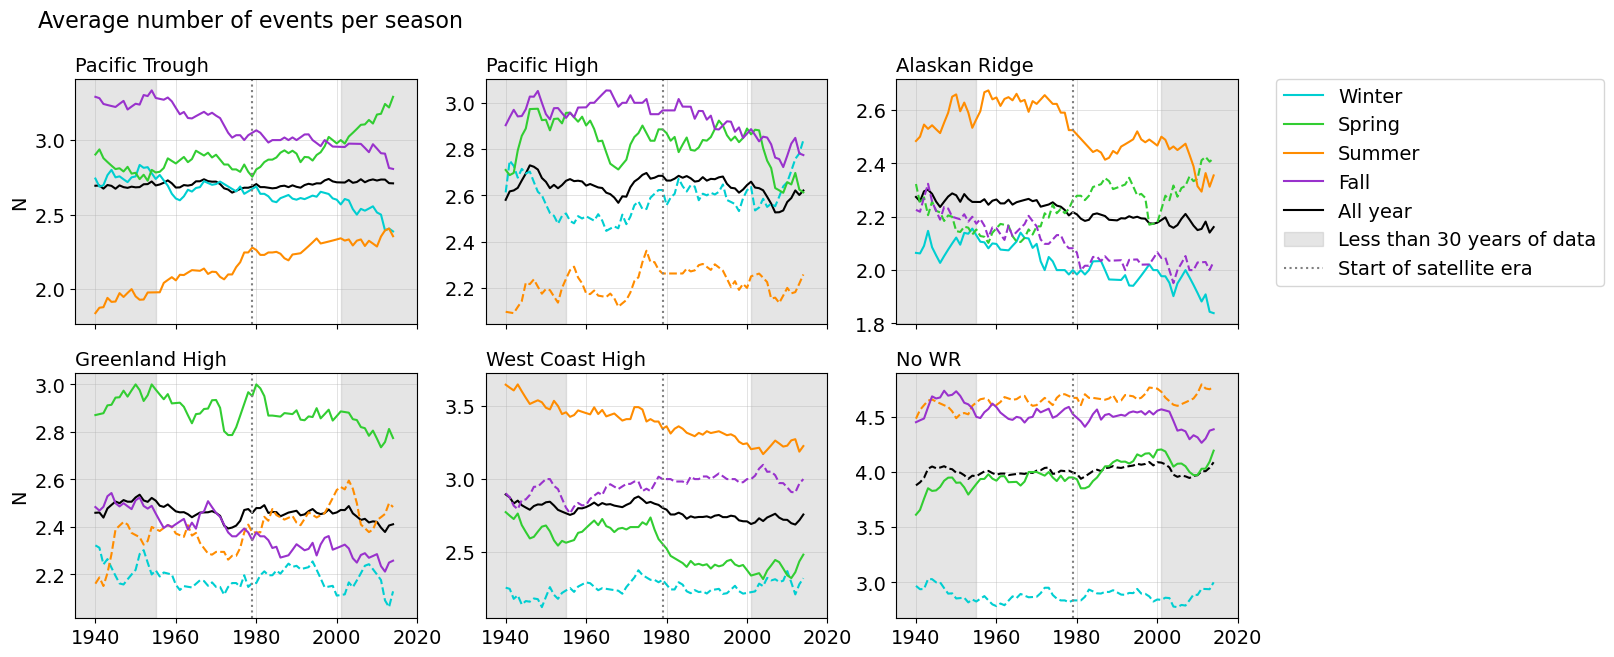

In [157]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_evfreq[:, wr]/4,index=years_trends)
    slope, p_value = compute_trend_significance(df_temp[0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
    if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} seasonal events per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_evfreq[:, wr]/4, color='k')
    else:
        ax.plot(years_trends, series_evfreq[:, wr]/4, color='k',ls = '--')
        
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_evfreq_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp[0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
        if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} seasonal events per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_evfreq_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_evfreq_seasonal[season][:, wr], color=colors_seasons[iseason],ls ='--')
        ax.plot([1,2],series_evfreq_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_evfreq_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2001, 2020, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1935,2020)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('N',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average number of events per season',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalEventFreqTrends',bbox_inches='tight')


## Trends in duration of events

In [158]:
def get_durations_events(df_events_temp):
    mean_duration_overall = df_events_temp.groupby('class')['duration'].mean()
    # Calculate mean duration of events for each class stratified by seasons
    mean_duration_by_season = df_events_temp.groupby(['season', 'class'])['duration'].mean()
    return mean_duration_overall, mean_duration_by_season

In [159]:
series_duration = []
series_duration_seasonal = {}
for season in seasons:
    series_duration_seasonal[season] = []

for year in years_trends:
    series_duration.append(get_durations_events(dict_events[year])[0].values)
    for season in seasons:
        series_duration_seasonal[season].append(get_durations_events(dict_events[year])[1][season])

series_duration = np.array(series_duration)
for season in seasons:
    series_duration_seasonal[season] = np.array(series_duration_seasonal[season])

*** Pacific Trough ***
Trend (slope): 0.09470144933440575 days per decade
P-value: 1.0119774404152001e-41
*** Pacific Trough Winter ***
Trend (slope): 0.2708194335172809 days per decade
P-value: 8.536826948864071e-36
*** Pacific Trough Fall ***
Trend (slope): 0.14507599538179314 days per decade
P-value: 7.907248195391703e-37
*** Pacific High Winter ***
Trend (slope): -0.08685850032026786 days per decade
P-value: 7.752265866264657e-17
*** Pacific High Fall ***
Trend (slope): 0.09179795610280246 days per decade
P-value: 1.905157528845075e-18
*** Alaskan Ridge ***
Trend (slope): -0.027923396888451454 days per decade
P-value: 1.2958037132245273e-24
*** Greenland High ***
Trend (slope): 0.0979772224843587 days per decade
P-value: 5.5867028411548386e-36
*** Greenland High Winter ***
Trend (slope): 0.20407425298375334 days per decade
P-value: 2.3838854057095346e-31
*** Greenland High Spring ***
Trend (slope): -0.07174457987664765 days per decade
P-value: 6.530176392357276e-27
*** Greenland Hi

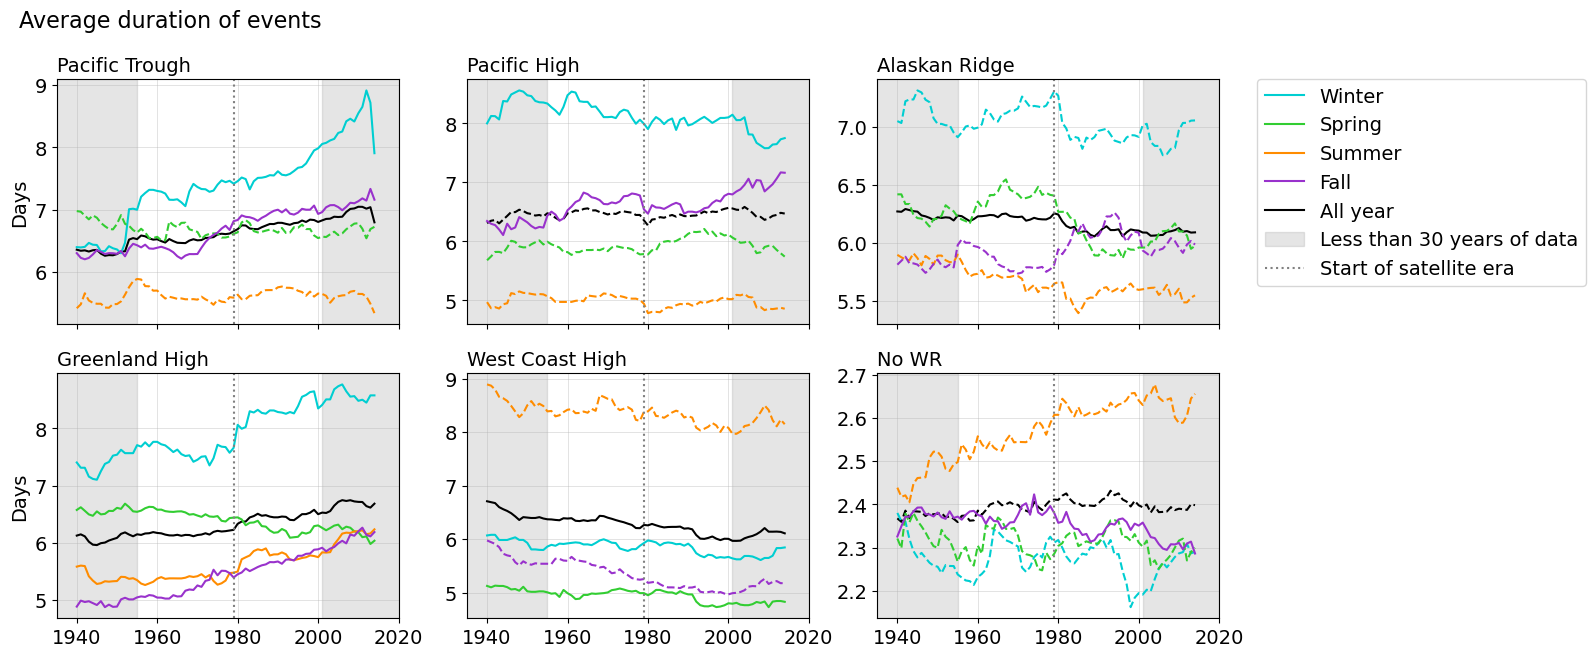

In [160]:
# Define the number of rows and columns for the subplot grid
num_rows = 2
num_cols = 3

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 7), sharex=True)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Loop through each WR (assuming 6 WRs as per your original code)
for wr in range(6):
    ax = axes[wr]  # Select the current axis
    df_temp = pd.DataFrame(series_duration[:, wr],index=years_trends)
    slope, p_value = compute_trend_significance(df_temp[0])
    slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
    if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
        print('***',names_wrs_withclimo[wr],'***')
        print(f"Trend (slope): {slope*10} days per decade")
        print(f"P-value: {p_value}")
        ax.plot(years_trends, series_duration[:, wr], color='k')
    else:
        ax.plot(years_trends, series_duration[:, wr], color='k',ls='--')
    for iseason, season in enumerate(seasons):
        df_temp = pd.DataFrame(series_duration_seasonal[season][:, wr],index=years_trends)
        slope, p_value = compute_trend_significance(df_temp[0])
        slope2, p_value2 = compute_trend_significance(df_temp.loc['1979':][0])
        if (p_value<0.01)&(p_value2<0.01)&(slope*slope2 > 0):
            print('***',names_wrs_withclimo[wr],season,'***')
            print(f"Trend (slope): {slope*10} days per decade")
            print(f"P-value: {p_value}")
            ax.plot(years_trends, series_duration_seasonal[season][:, wr], color=colors_seasons[iseason])
        else:
            ax.plot(years_trends, series_duration_seasonal[season][:, wr], color=colors_seasons[iseason],ls = '--')

        ax.plot([1,2],series_duration_seasonal[season][:, wr][[1,2]],color=colors_seasons[iseason], label=season)
    ax.plot([1,2],series_duration_seasonal[season][:, wr][[1,2]],color='k', label='All year')
    # Add the gray shaded area
    ax.axvspan(2001, 2020, color='gray', alpha=0.2)
    ax.axvspan(1935, 1955, color='gray', alpha=0.2,label = 'Less than 30 years of data')
    ax.axvline(1979,color='gray',ls = 'dotted',label = 'Start of satellite era')
    # Customize tick size
    ax.tick_params(axis='both', which='major', labelsize=14)  # Adjust major tick label size
    ax.tick_params(axis='both', which='minor', labelsize=8)   # Adjust minor tick label size if needed

    # ax.legend(loc='upper left')
    ax.set_title(names_wrs_withclimo[wr], loc='left',fontsize=14)
    ax.set_xlim(1935,2020)
    ax.grid(alpha=0.5, lw=0.5)
    if (wr==0)|(wr==3):
        ax.set_ylabel('Days',fontsize=14)

plt.legend(bbox_to_anchor=(2.1, 2.24),fontsize=14)
plt.suptitle('Average duration of events',x=0.1,ha='left',fontsize=16)
# Adjust layout and spacing
# plt.tight_layout()

# Show the plot
plt.savefig(f'{path_figs}SeasonalDurationTrends',bbox_inches='tight')
